<a href="https://colab.research.google.com/github/IrynaBarnych/AI13/blob/lab/module4/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D0%BA%D0%BB%D0%B0%D1%81%D0%B8%D1%84%D1%96%D0%BA%D1%96%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [171]:
import pandas as pd
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про діабет

In [172]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/Healthcare-Diabetes.csv',
                 index_col='Id')

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [173]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.000000,0.416873,0.234415,0.483333,1
2,0.058824,0.427136,0.540984,0.263636,0.000000,0.330025,0.116567,0.166667,0
3,0.470588,0.919598,0.524590,0.000000,0.000000,0.289082,0.253629,0.183333,1
4,0.058824,0.447236,0.540984,0.209091,0.111111,0.348635,0.038002,0.000000,0
5,0.000000,0.688442,0.327869,0.318182,0.198582,0.534739,0.943638,0.200000,1


Потрібно на основі інформації пацієнта виявити наявність діабету `Outcome`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [174]:
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.000000,0.416873,0.234415,0.483333,1
2,0.058824,0.427136,0.540984,0.263636,0.000000,0.330025,0.116567,0.166667,0
3,0.470588,0.919598,0.524590,0.000000,0.000000,0.289082,0.253629,0.183333,1
4,0.058824,0.447236,0.540984,0.209091,0.111111,0.348635,0.038002,0.000000,0
5,0.000000,0.688442,0.327869,0.318182,0.198582,0.534739,0.943638,0.200000,1


In [175]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['Outcome'])
y = df['Outcome']

dataset = MyDataset(X, y)

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [177]:
from torch.utils.data import DataLoader

batch_size = 128
train_dl = DataLoader(dataset_train,  # датасет з даними
                      batch_size=batch_size,  # кількість даних в одному пакеті
                      shuffle=True)  # чи треба перемішувати дані)

test_dl = DataLoader(dataset_test,  # датасет з даними
                     batch_size=batch_size,  # кількість даних в одному пакеті
                     shuffle=True)  # чи треба перемішувати дані)

# Завдання 3
Створіть нейромережу

In [178]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.sigmoid(out)
        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.numpy()


model = BinaryClassifier(8, 100, 1)
model

BinaryClassifier(
  (linear1): Linear(in_features=8, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

In [179]:
from torchsummary import summary

summary(model, input_size=(8,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             900
            Linear-2                    [-1, 1]             101
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [180]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = nn.BCELoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [181]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().numpy()
            y = y.detach().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.detach().numpy()
                y = y.detach().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [182]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=20,
                metrics=[accuracy_score, roc_auc_score],
                task='binary')

train() called: model=BinaryClassifier, opt=Adam(lr=0.001000), epochs=20, device=cpu

Epoch    1    0sec	loss:       0.67	val_loss:      0.655	accuracy_score:      0.653	val_accuracy_score:      0.662	roc_auc_score:      0.416	val_roc_auc_score:      0.333	
Epoch    2    0sec	loss:      0.652	val_loss:      0.643	accuracy_score:      0.654	val_accuracy_score:      0.662	roc_auc_score:      0.391	val_roc_auc_score:      0.446	
Epoch    3    0sec	loss:      0.643	val_loss:      0.632	accuracy_score:      0.654	val_accuracy_score:      0.662	roc_auc_score:      0.586	val_roc_auc_score:      0.701	
Epoch    4    0sec	loss:      0.633	val_loss:      0.622	accuracy_score:      0.654	val_accuracy_score:      0.662	roc_auc_score:      0.722	val_roc_auc_score:      0.749	
Epoch    5    0sec	loss:      0.622	val_loss:       0.61	accuracy_score:      0.654	val_accuracy_score:      0.661	roc_auc_score:      0.755	val_roc_auc_score:      0.775	
Epoch    6    0sec	loss:      0.611	val_loss:      0.5

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [183]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()

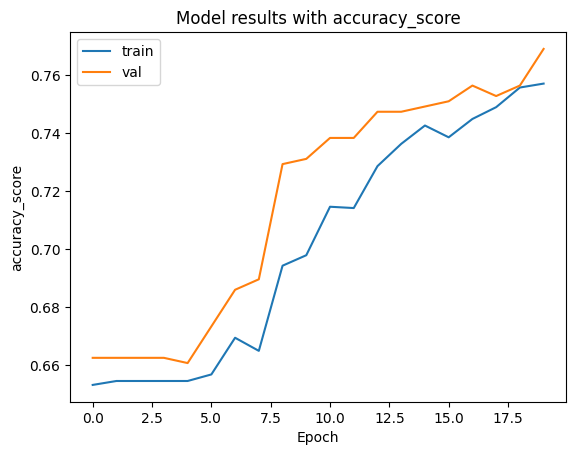

In [184]:
plot_metric(history, 'accuracy_score')

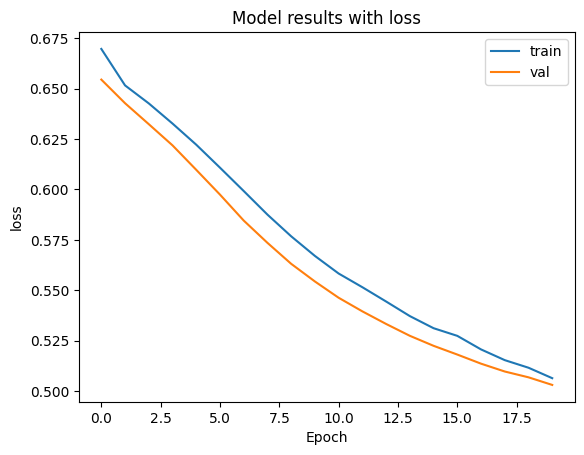

In [185]:
plot_metric(history, 'loss')

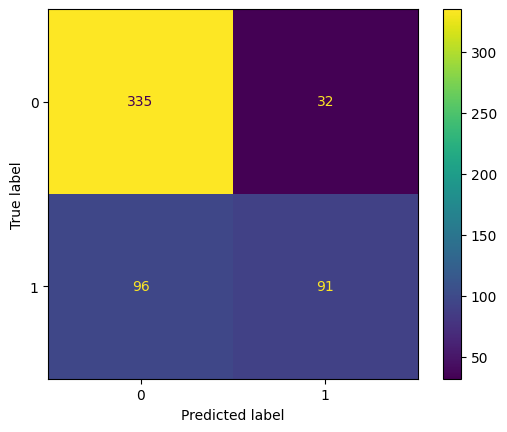

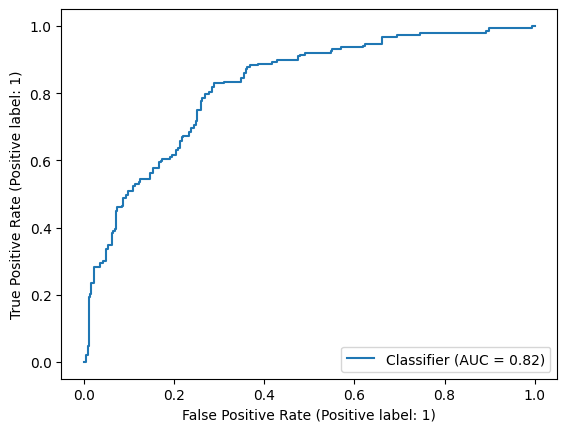

In [187]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)